In [1]:
import codecs
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
import math
import numpy as np
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from scipy import signal
import scipy.io as scio
import pandas as pd
from scipy.signal import hilbert
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle

In [2]:
dataset_folder_path = '/content/drive/MyDrive/Brain/EEG_data/Bands/'
model_path = '/content/drive/MyDrive/Brain/EEG_Models/'
model_name = 'EEG_16_3obj_normalized_left-right-average'
channels_list = ['f3', 'f4','c3','c4', 'p3', 'p4']  # file names format 'c3_input_alpha.txt'
values_per_file = 36000
values_per_split = 9000
fs = 256 # Hz

channel_num = len(channels_list)

# Creating the DATASET

In [3]:
dataset_files_list = [] 
dataset_files_list = os.listdir(dataset_folder_path)

print(dataset_files_list)
object_num = len(dataset_files_list)

['eeg_bands_object_1_fear', 'eeg_bands_object_2_joy', 'eeg_bands_object_1_joy', 'eeg_bands_object_2_fear', 'eeg_bands_object_3_joy', 'eeg_bands_object_3_fear']


In [ ]:
label_list = []

for item in dataset_files_list:
  if 'joy' in item:
    label_list.append('joy')
  elif 'fear' in item:
    label_list.append('fear')
print(label_list)    

['fear', 'joy', 'joy', 'fear', 'joy', 'fear']


# fs=256 Hz
Theta - 4 - 7.5 Hz

Alpha - 8 - 13.5 Hz

Beta -  14 - 30 Hz

Gamma - 30.5 - 40 Hz

In [ ]:
def formatDataFromTXT(contents):
  contents_list = contents.splitlines()
  contents_array = np.array([])

  contents_array = np.array([float(a) for a in contents_list])
  if (contents_array.shape[0]-values_per_file)%2==0:
    a = int((contents_array.shape[0]-values_per_file)/2)
    contents_array = contents_array[a:-a]
  else:
       a = int((contents_array.shape[0]-values_per_file)/2)
       contents_array = contents_array[a+1:-a]
  
  return contents_array 
def ReadObjectData(object_folder_name):
  object_data_3d = np.empty((channel_num, 4, values_per_file), float)  # object = (channels, bands, values) = (6, 4, values)
  i = 0 # channel counter
  for channel_name in channels_list:
    channel_data_2d = ReadChannelData(channel_name)
    object_data_3d[i] = channel_data_2d
    i+=1

  return object_data_3d

def ReadChannelData(channel_name):
  channel_data_2d = np.empty((4, values_per_file), float) # channel = (bands, values)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_alpha.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  alpha_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_beta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  beta_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_gamma.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  gamma_data = formatDataFromTXT(contents)
  with codecs.open((dataset_folder_path + object_folder_name + '/' + channel_name + '/' + channel_name + '_input_theta.txt'), 'r', encoding='utf-8', errors='ignore') as fdata:
      contents = fdata.read()
  theta_data = formatDataFromTXT(contents)
  channel_data_2d[0] = theta_data
  channel_data_2d[1] = alpha_data
  channel_data_2d[2] = beta_data
  channel_data_2d[3] = gamma_data

  return channel_data_2d

(objects, channels, bands, values) = (4, 6, 4, 40000)

In [ ]:
objects_data_4d = np.empty((object_num, channel_num, 4, values_per_file), float) # (objects, channels, bands, values) = (6, 6, 4, 40000)

j = 0 # object counter 

for object_folder_name in dataset_files_list:
  object_data_3d = ReadObjectData(object_folder_name)
  objects_data_4d[j] = object_data_3d
  print(j)
  j+=1
  
print(objects_data_4d)

0
1
2
3
4
5
[[[[ 1.2163347e+00  1.0383467e+00  8.2509065e-01 ... -1.9792954e+00
    -1.6432601e+00 -1.2934436e+00]
   [-1.5886780e+00 -1.1561486e+00 -6.1206747e-01 ... -2.9903987e+00
    -3.6006064e+00 -3.9734980e+00]
   [-8.1971614e-01  9.8412436e-01  2.3160232e+00 ...  4.3597404e+00
     4.6242641e+00  4.0487924e+00]
   [ 3.7330706e+00  1.2417134e+00 -1.6622964e+00 ...  3.3027287e+00
     1.2366279e+00 -1.4081990e+00]]

  [[ 1.4299817e+00  1.4230998e+00  1.3729154e+00 ... -1.0346451e+00
    -7.0845946e-01 -3.5900240e-01]
   [-3.6779808e+00 -2.5481862e+00 -1.2499134e+00 ...  4.8932385e-01
    -4.0109446e-01 -1.2256754e+00]
   [-3.0729542e+00 -1.3614485e+00  7.1008017e-01 ...  7.3081506e+00
     6.8366956e+00  5.1118133e+00]
   [ 5.4346685e-01 -2.5533120e+00 -3.5394420e+00 ...  1.2554958e+00
     3.9362832e-01 -4.8249398e-01]]

  [[-5.2720819e-02 -5.3108460e-02 -6.0008251e-02 ... -2.6589391e+00
    -2.7025108e+00 -2.6743058e+00]
   [ 2.6211517e-01  8.0497669e-01  1.3654783e+00 ... -2.0

In [ ]:
print(objects_data_4d.shape)
print(objects_data_4d[0, 0, 0, :]) # [0, 0, 0, :] == first object, c3 (first channel), theta band, values 

(6, 6, 4, 36000)
[ 1.2163347   1.0383467   0.82509065 ... -1.9792954  -1.6432601
 -1.2934436 ]


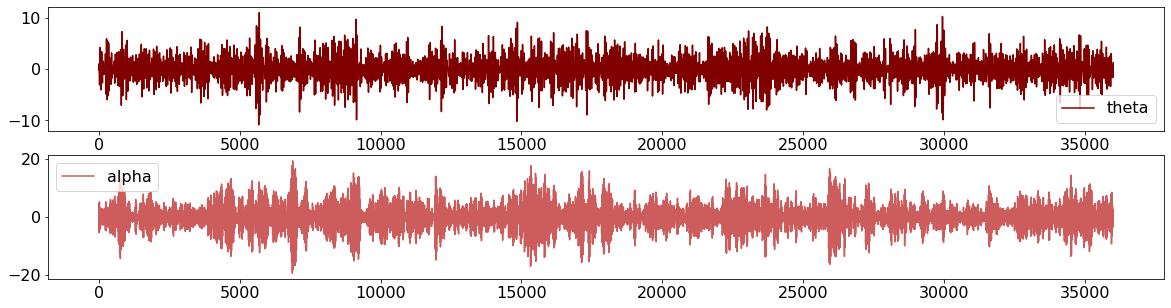

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 1, :], label='alpha', color='indianred')
plt.legend()

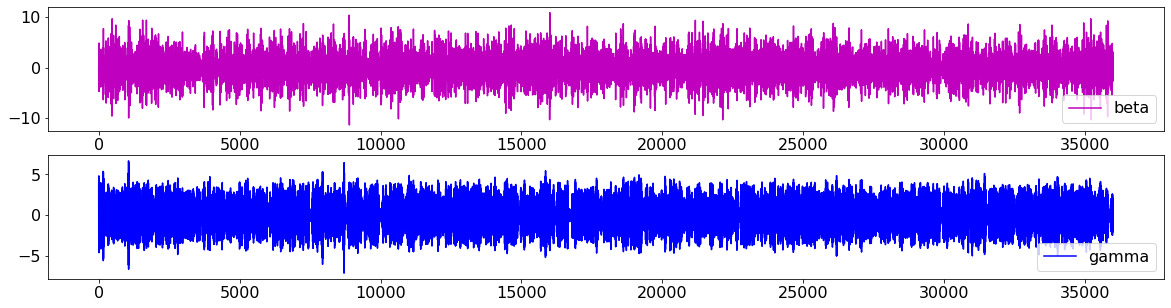

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d[2, 3, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d[2, 3, 3, :], label='gamma', color='b')
plt.legend()

(objects, channels, bands, values) = (4, 6, 4, 40000)

# **NORMALIZE**

In [ ]:
from sklearn import preprocessing

def StandardizeByChannel(data):
  objects_data_4d_scaled = np.empty((object_num, channel_num, 4, values_per_file), float)  # (objects, channels, bands, values) = (4, 6, 4, 40000)
  j = 0 # object counter
  i = 0 # channel counter
  for j in range(0,object_num):
    for i in range(0,channel_num):
      objects_data_4d_scaled[j, i, :, :] = preprocessing.normalize(data[j, i, :, :])
      i+=1
    j+=1  

  return objects_data_4d_scaled

In [ ]:
objects_data_4d = StandardizeByChannel(objects_data_4d)

**SPLIT**

In [ ]:
objects_data_4d_split = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, values_per_split))
j = 0

for obj in range(0, object_num):
  i = 0

  while i < values_per_file:
      objects_data_4d_split[j] = objects_data_4d[obj,:,:,i:(i+values_per_split)]
      i+=values_per_split
      j+=1

print(objects_data_4d_split)      
print(objects_data_4d_split.shape) 

[[[[ 2.36039581e-03  2.01499570e-03  1.60115510e-03 ... -5.70284292e-05
    -1.25776626e-03 -2.48506085e-03]
   [-2.13987733e-03 -1.55727981e-03 -8.24427168e-04 ... -1.30374758e-03
    -4.53788884e-04  4.73039291e-04]
   [-1.29365924e-03  1.55312493e-03  3.65510043e-03 ...  1.83776467e-03
     1.38933469e-04 -1.61666408e-03]
   [ 6.66410549e-03  2.21664950e-03 -2.96745488e-03 ... -1.31041626e-03
    -5.67551119e-04  5.62814463e-04]]

  [[ 2.80482382e-03  2.79132539e-03  2.69289168e-03 ...  3.54402401e-03
     2.10865117e-03  5.75461477e-04]
   [-4.69888900e-03 -3.25549391e-03 -1.59685562e-03 ... -1.16993121e-04
     7.94634762e-04  1.63139749e-03]
   [-5.17832712e-03 -2.29421763e-03  1.19657735e-03 ... -1.55561051e-03
    -3.28163855e-03 -4.06716306e-03]
   [ 1.11696459e-03 -5.24771489e-03 -7.27446646e-03 ... -2.20028090e-03
    -1.13147516e-03  4.75019900e-04]]

  [[-1.49278308e-04 -1.50375908e-04 -1.69912576e-04 ...  1.05836175e-03
     5.12978526e-04 -8.10899988e-05]
   [ 6.55315711

'c3', 'c4', 'f3', 'f4', 'p3', 'p4'

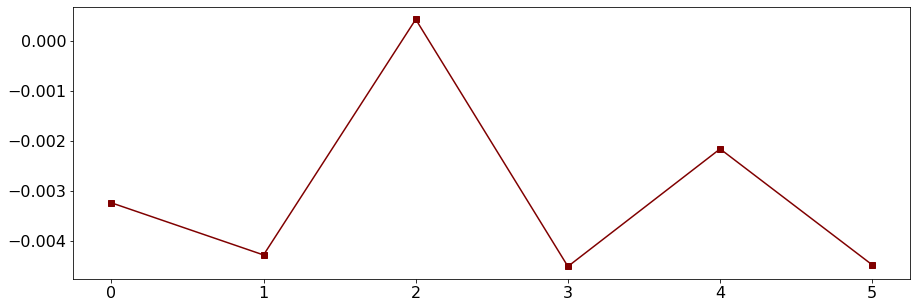

In [ ]:
b = np.array(objects_data_4d_split[1, :, 2, 0]) 
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

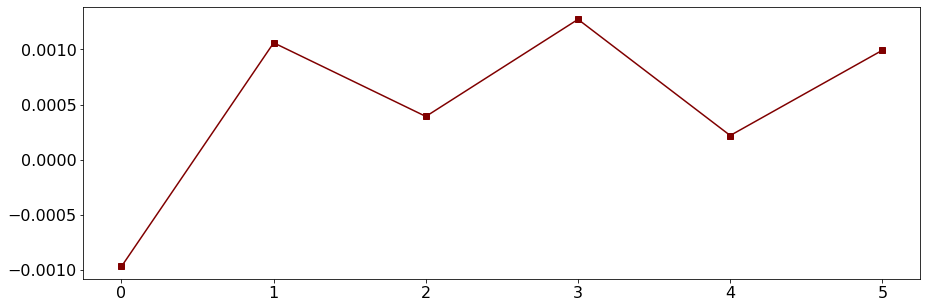

In [ ]:
b = np.array(objects_data_4d_split[5, :, 2, 0]) # joy

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(b, label='c3 - theta', color='maroon', marker='s')

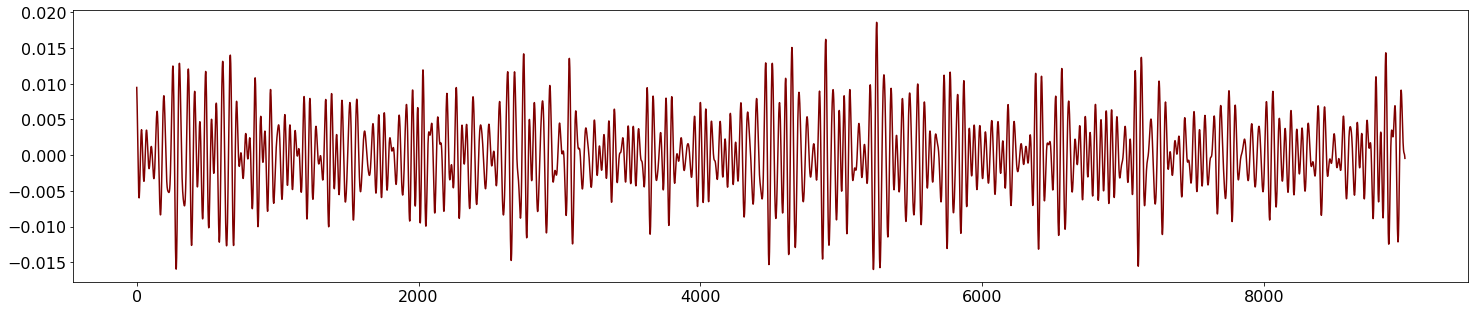

In [ ]:
b = np.array(objects_data_4d_split[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

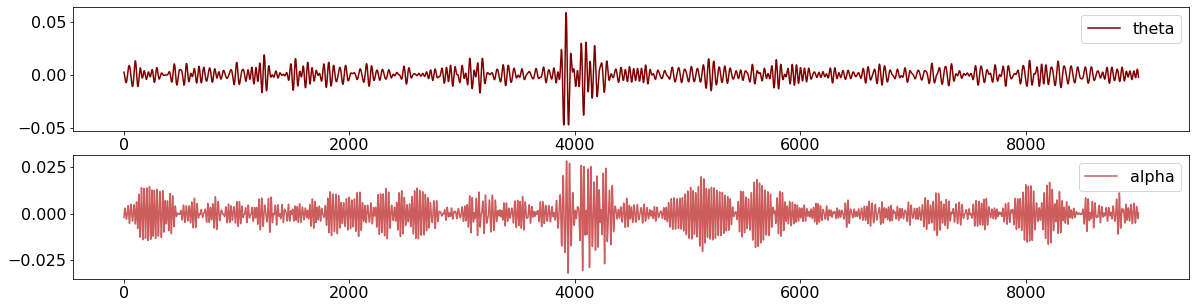

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 0, :], label='theta', color='maroon')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 1, :], label='alpha', color='indianred')
plt.legend()

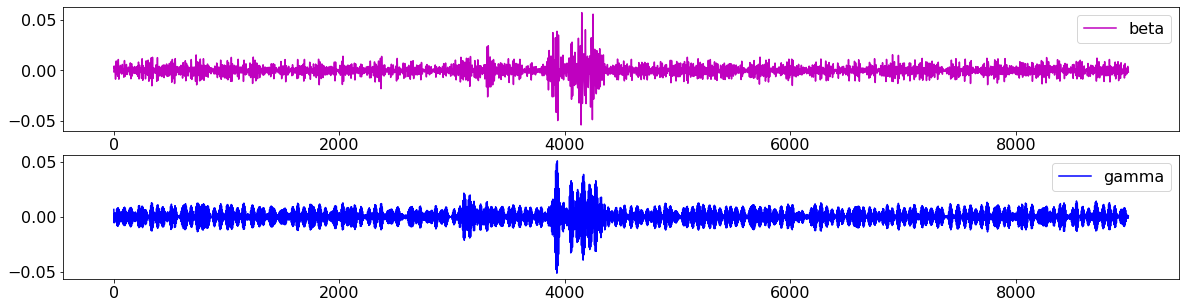

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,5)

plt.subplot(211)
plt.plot(objects_data_4d_split[0, 0, 2, :], label='beta', color='m')
plt.legend()
plt.subplot(212)
plt.plot(objects_data_4d_split[0, 0, 3, :], label='gamma', color='b')
plt.legend()

In [ ]:
objects_data_4d_split[0,:,:,:].shape

(6, 4, 9000)

In [ ]:
np.var(objects_data_4d_split[2,:,:,:])

2.8247023317420378e-05

In [ ]:
label_list = [ item for item in label_list for repetitions in range(int(values_per_file/values_per_split)) ]
label_list

['fear',
 'fear',
 'fear',
 'fear',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'fear',
 'fear',
 'fear',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
i=0
while i!=16:
  rat = np.var(objects_data_4d_split[i,:,:,:])/np.median(objects_data_4d_split[i,:,:,:])
  print(label_list[i], " -> ", rat)
  i+=1

fear  ->  -17.44558853770869
fear  ->  -24.591591412112773
fear  ->  3.3570502256760277
fear  ->  -4.851947632827545
joy  ->  -1.615613927265319
joy  ->  2.590210985563997
joy  ->  -13.107818755462214
joy  ->  -1.7521944590413852
joy  ->  -37.104842086745705
joy  ->  -5.285302370738597
joy  ->  -5.846552572762992
joy  ->  -2.847761276571895
fear  ->  1.026752562112947
fear  ->  9.472082432076682
fear  ->  44.556239419434604
fear  ->  -21.15344906394303


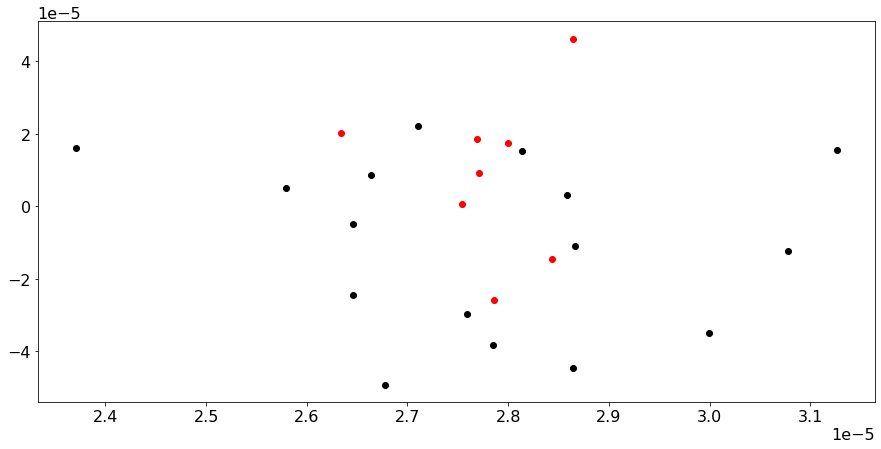

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 16})

x = np.array( [ np.var(item) for item in objects_data_4d_split[:4,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[:4,3,3,:]])
plt.plot(x, y, 'o', color='black')
x = np.array( [ np.var(item) for item in objects_data_4d_split[4:12,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[4:12,3,3,:]])
plt.plot(x, y, 'o', color='red')
x = np.array( [ np.var(item) for item in objects_data_4d_split[12:,3,3,:]])
y = np.array( [ np.median(item) for item in objects_data_4d_split[12:,3,3,:]])
plt.plot(x, y, 'o', color='black')


In [ ]:
x

array([2.81420984e-05, 2.64584014e-05, 2.86608740e-05, 2.78497311e-05,
       2.71026989e-05, 2.85882182e-05, 2.86419532e-05, 2.67782387e-05,
       2.66330619e-05, 2.99900985e-05, 3.07830143e-05, 2.37049354e-05])

Shuffle

In [ ]:
objects_data_4d_split, label_list = shuffle(objects_data_4d_split, label_list)
print(label_list)

['joy', 'fear', 'fear', 'joy', 'joy', 'joy', 'joy', 'fear', 'fear', 'joy', 'joy', 'fear', 'joy', 'joy', 'fear', 'joy', 'fear', 'fear', 'fear', 'fear', 'fear', 'joy', 'joy', 'fear']


np.save((model_path + 'DATA_objects_data_4d_split_right-left-3-4-10000'), objects_data_4d_split)

np.save((model_path + 'DATA_objects_data_4d_split_right-left-3-4-10000_label_list'), label_list)


objects_data_4d_split = np.load(model_path + 'DATA_objects_data_4d_split.npy')

label_list = np.load(model_path + 'DATA_label_list.npy')

In [4]:
objects_data_4d_split = np.load(model_path + 'DATA_3objects_data_4d_split_right-left-3-4-9000.npy')

label_list = np.load(model_path + 'DATA_3objects_data_4d_split_right-left-3-4-9000_label_list.npy')

In [5]:
label_list_0or1 = []
for label in label_list:
  if label == 'joy':
    label_list_0or1.append(0.)
  elif label == 'fear':
    label_list_0or1.append(1.)
    
label_list_0or1 = np.array(label_list_0or1)
print(label_list_0or1)  

[0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]


1 average value per 1000 values 

# EXTRACTION FUNCTION

In [6]:
objects_data_4d_split_extract = np.zeros((int(object_num*values_per_file/values_per_split), channel_num, 4, 10))

for i in range(0, int(object_num*values_per_file/values_per_split)): # object sample
  for j in range(0, channel_num): # channel
    for k in range(0, 4): # band
      for l in range(0,10): # value
        start = int(l*values_per_split/10)
        end = int((l+1)*values_per_split/10)
        objects_data_4d_split_extract[i, j, k, l] = np.average(objects_data_4d_split[i, j, k, start:end])

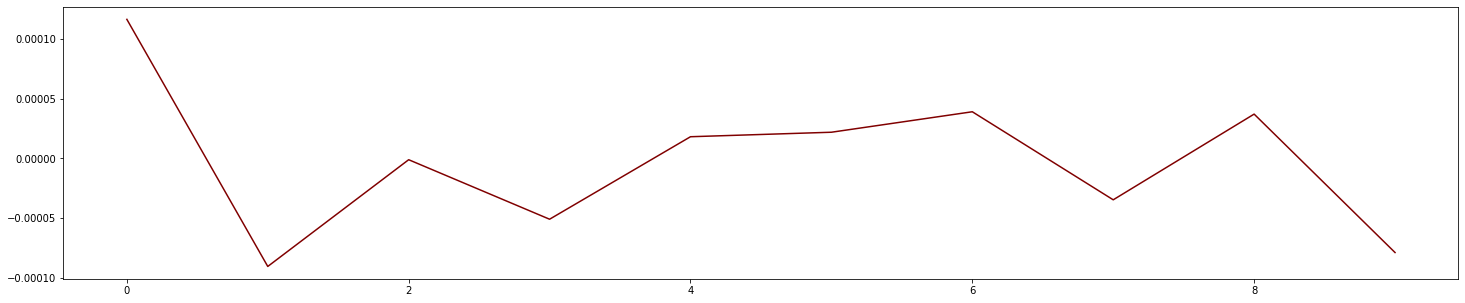

In [7]:
b = np.array(objects_data_4d_split_extract[10, 0, 0, :])

plt.rcParams["figure.figsize"] = (25,5)
plt.plot(b, label='c3 - theta', color='maroon')

# RATIO - LEFT/RIGHT HEMISPHERE 

In [8]:
def ChannelRatio(data):
  ratio_data = np.empty((int(object_num*values_per_file/values_per_split), int(channel_num/2), 4, 10), float)  # (objects, channels, bands, values) = (4, 6, 4, 40000)
  j = 0 # object counter
  i = 0 # channel counter
  for j in range(0,int(object_num*values_per_file/values_per_split)):
    for i in range(0,6,2):
      for h in range(0,3):
        ratio_data[j, h, :, :] = np.divide(data[j, i, :, :], data[j, i+1, :, :])
        #print(j, i, h)

  return ratio_data

In [9]:
objects_data_4d_split_extract_ratio = ChannelRatio(objects_data_4d_split_extract) 

# TRAIN / TEST 

In [10]:
num_1 = 0
num_0 = 0
i = 0
index_list = []

while len(index_list)<4:
  if (label_list_0or1[i] == 0) and (num_0!=2):
    index_list.append(i)
    num_0+=1
  elif (label_list_0or1[i] == 1) and (num_1!=2): 
    index_list.append(i)
    num_1+=1
  i+=1
print(i)

4


In [11]:
x_test = objects_data_4d_split_extract_ratio[index_list,:]
y_test = label_list_0or1[index_list]
print(y_test)

[0. 1. 1. 0.]


In [12]:
x_test

array([[[[-1.84491375e-01,  9.47786357e+00,  1.20145209e+00,
           3.16520517e+00,  1.46599511e+00,  3.95830849e+00,
           1.73096475e+00,  8.84144639e+00, -2.96205478e-01,
          -1.08306154e+00],
         [ 1.57256437e-01,  8.28428375e-01, -9.78030443e-01,
           4.72401930e-02,  7.20631312e-01, -8.48927270e+00,
           1.68965280e+00,  2.76895130e+00, -1.27337902e+00,
           5.09195404e-01],
         [-1.20045668e+00,  4.36324080e+00,  2.98273144e+01,
           6.47068036e-01,  8.19301009e-01,  1.02779201e+00,
           1.42632410e+00,  7.08521901e-01, -8.26249574e-03,
          -6.27184447e-01],
         [ 5.33990439e-02, -8.60332305e-01,  3.44802308e+00,
           2.39002211e+00, -3.21797056e+00, -1.22629516e+00,
          -2.56537261e+00,  3.85919894e-01,  6.38988077e-01,
           8.13392649e-01]],

        [[-1.84491375e-01,  9.47786357e+00,  1.20145209e+00,
           3.16520517e+00,  1.46599511e+00,  3.95830849e+00,
           1.73096475e+00,  8.84

In [13]:
x_train = np.delete(objects_data_4d_split_extract_ratio, index_list, 0)
y_train = np.delete(label_list_0or1, index_list)
print(x_train.shape)

(20, 3, 4, 10)


Reshape Data

In [14]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1,1))

In [15]:
y_train

array([[[0.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[1.]],

       [[0.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[1.]]], dtype=float32)

In [15]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='tanh', input_shape=(int(channel_num/2), 4, 10)))
#model.add(Conv2D(16, (2,2), activation='tanh'))
#model.add(Flatten())
#model.add(Dense(64, activation='tanh', input_shape=(int(channel_num/2), 4, 10)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

In [16]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 2, 32)          2912      
                                                                 
 dense (Dense)               (None, 1, 2, 32)          1056      
                                                                 
 dense_1 (Dense)             (None, 1, 2, 16)          528       
                                                                 
 dense_2 (Dense)             (None, 1, 2, 8)           136       
                                                                 
 dense_3 (Dense)             (None, 1, 2, 1)           9         
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


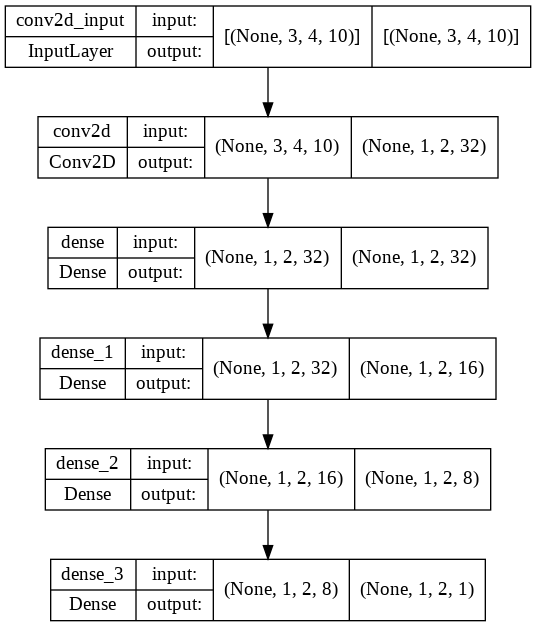

In [19]:
plot_model(model, to_file=(model_path+'NNmodel_plot.png'), show_shapes=True, show_layer_names=True)

In [17]:
history = model.fit(x_train, y_train, epochs=200, batch_size=4, validation_data = (x_test, y_test))

Epoch 1/200
5/5 [==============================] - 1s 59ms/step - loss: 0.7839 - accuracy: 0.4000 - val_loss: 0.7039 - val_accuracy: 0.5000
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.6450 - accuracy: 0.5500 - val_loss: 0.6761 - val_accuracy: 0.6250
Epoch 3/200
5/5 [==============================] - 0s 9ms/step - loss: 0.5613 - accuracy: 0.8500 - val_loss: 0.6591 - val_accuracy: 0.6250
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 0.5024 - accuracy: 0.8500 - val_loss: 0.6399 - val_accuracy: 0.7500
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4510 - accuracy: 0.9250 - val_loss: 0.6252 - val_accuracy: 0.7500
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4090 - accuracy: 0.9500 - val_loss: 0.6175 - val_accuracy: 0.7500
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - loss: 0.3707 - accuracy: 0.9750 - val_loss: 0.6199 - val_accuracy: 0.6250
Epoch 8/200
5/5 [========

In [18]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 213ms/step - loss: 1.4801 - accuracy: 0.7500
Accuracy: 75.00


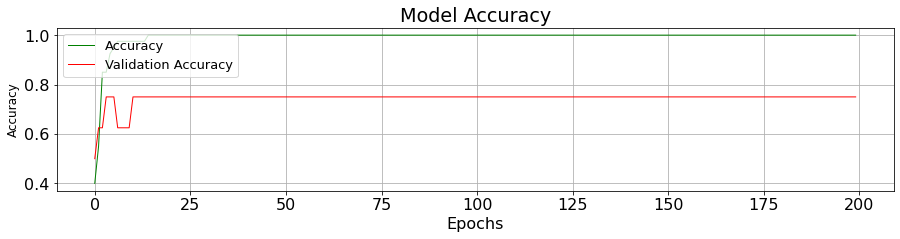

In [19]:
plt.figure(figsize=(15,3), frameon=True)
plt.rcParams.update({'font.size': 16})

plt.plot(history.history['accuracy'], 'g', linewidth=1)
plt.plot(history.history['val_accuracy'], 'r', linewidth=1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

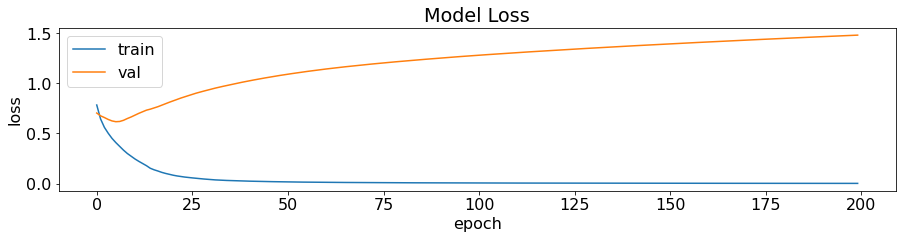

In [20]:
plt.figure(figsize=(15,3), frameon=True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Figure size 1080x360 with 0 Axes>

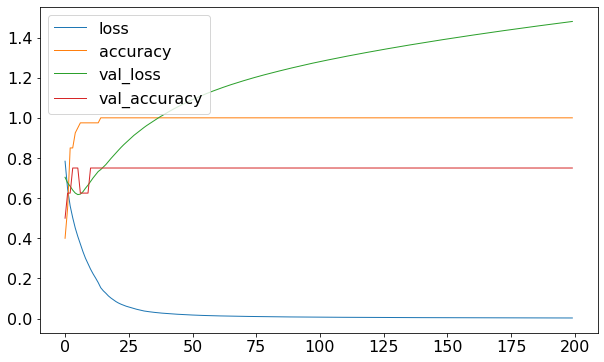

In [21]:
plt.figure(figsize=(15,5), frameon=True)
pd.DataFrame(history.history).plot(figsize=(10,6),linewidth=1)
plt.show()

In [ ]:
-

In [ ]:
model.save(os.path.join(model_path, (model_name + '_MODEL.h5')))
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open((model_path + model_name + '_MODEL.json'), "w") as json_file:
    json_file.write(model_json)

Saved trained model at /content/drive/MyDrive/Brain/EEG_Models/ 


In [ ]:
json_file = open(model_path + model_name + '_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_path + model_name + '_MODEL.h5')
print("Loaded model from disk")

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk
